In [1]:
import pandas as pd
import os
import zipfile
import json
import glob
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

group 1 - 2089 unique hashes
group 2 - 3357 unique hashes
738 common hashes

In [12]:
def fetch_files(group,db,scale,k):
    hash_matches_path = f"..\\snakemake-workflow\\output\\{group}\\{db}.{scale}\\hash_matches\\"
    ext = f"*{k}.query-matches.sig"

    target_files = glob.glob(os.path.join(hash_matches_path,ext))
    return target_files



def sig2dict(target_files):    
    data_dict ={}
    for i in range(len(target_files)):
        sample = target_files[i].split('\\')[-1].split('.')[0]
        with open(target_files[i]) as f:
            js = json.loads(f.read())
        data_dict[sample] = [js[0]['signatures'][0]['mins'],js[0]['signatures'][0]['abundances']]
    return data_dict


def dict2df(data_dict):
    df = pd.DataFrame(index=data_dict.keys())
    for sample, (hashes, values) in data_dict.items():
        for hash_val, value in zip(hashes, values):
            df.loc[sample, hash_val] = value #slow and defragmented? apparently

    # Fill NaN values with 0
    return df.fillna(0)

def group_df(group,db,scale,k):
    group_files = fetch_files(group,db,scale,k)
    group_dict = sig2dict(group_files)
    group_df = dict2df(group_dict)
    group_df['group'] = group
    return group_df

def combine_groups(group1_df, group2_df):   
    combined_df = pd.concat([group1_df,group2_df], axis=0)
    combined_df = combined_df.fillna(0)
    return combined_df
    
def fit_rf(combined_df,output_dir):    
    y = combined_df['group']
    X = combined_df.drop('group',axis=1)

    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

    model = RandomForestClassifier(n_estimators=100, random_state=42)

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.2f}")

    # Build the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print(cm)

    # Display the confusion matrix using a heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.savefig(os.path.join(output_dir, "confusion_matrix.png"))

    # feature importance
    feature_importances = model.feature_importances_
    importance_df = pd.DataFrame({'Hashes': X.columns, 'Importance': feature_importances})
    importance_df = importance_df.sort_values(by='Importance', ascending=False)
    importance_df.to_csv(os.path.join(output_dir, "feature_imp.csv"), index=False)
    return importance_df


In [3]:
group1='weight_loss'
group2='adolescent'
db ='all_chloroplast'
scale = '100'
k='21'
group1_df = group_df(group1,db,scale,k)
group2_df =group_df(group2,db,scale,k)

In [4]:
1/2018


0.0004955401387512388

In [5]:
combined_df = combine_groups(group1_df,group2_df)

Accuracy: 1.00
[[74  0]
 [ 0 11]]


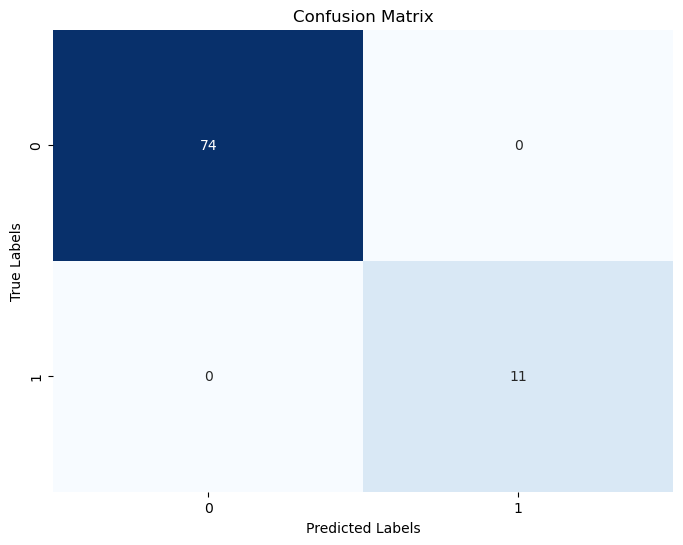

In [6]:
importance_df =fit_rf(combined_df, '../test/')

feature importance

add # samples with hash in group1/group2; avg abundance
sourmash compare containment
sourmash sig kmer
mumur hash inverse


In [13]:
importance_df[:50]

,Feature,Importance
136,157322820467948774,0.061463
27,25927711859011030,0.056003
128,145007500381155718,0.051341
153,180864512487652128,0.034232
170,22395183723216288,0.033736
98,108817344815512168,0.030555
58,67236570887032679,0.028001
63,70260550623951404,0.025293
245,124209537665470923,0.019767
62,70080496283005950,0.019588


In [9]:
def hashes2sig(importance_df,n,name,k)
    

SyntaxError: expected ':' (1633820744.py, line 1)

In [11]:
sig_format =[{"class":"sourmash_signature","email":"","hash_function":"0.murmur64","filename":None,
            "name":"ERR11520689-known","license":"CC0","signatures":[{"num":0,"ksize":51,"seed":42,"max_hash":184467440737095520,
            "mins":[5756550895798050,18258183296097495,33184746805409822,64575427079866475,90221529221383823,128845925818673832,130328166939714435,178750497274472558,179326412510026308],
            "md5sum":"ec34a9d81ea0b3594b5d350bca52e359","abundances":[258,105,1,1,2,5,11,1,2063],"molecule":"dna"}],"version":0.4}]

In [ ]:
sig_format[0]['signatures'][0]['mins'] = importance_df['Feature'][:50].tolist()
sig_format[0]['signatures'][0]['abundances'] = importance_df['Importance'][:50].tolist()
sig_format[0]['name']='feat_imp_test'

sig_format[0]['signatures'][0]['ksize']=21

In [ ]:
with open("../test/feature_imp.sig", "w") as json_file:
    json.dump(sig_format, json_file)


histgram of hashes